<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S42_logistics_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle
from matplotlib.transforms import Affine2D

import gtsam
from gtbook.display import show

N = 5
indices = range(1, N+1)
u = {k:gtsam.symbol('u',k) for k in indices[:-1]} # controls u_k
x = {k:gtsam.symbol('x',k) for k in indices}      # states x_k

# Moving in 2D

> Omniwheels are a great way to move omnidirectionally in 2D.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [3]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(4, 2, "steampunk", 1))

## Omni Wheels
> Omni wheels make omnidirectional movement possible.

An [omni wheel](https://en.wikipedia.org/wiki/Omni_wheel) is a wheel that -instead of a tire- has small rollers along its rim, whose axes are arranged perpendicular to the wheel's own axis. Because of this, unlike a conventional wheel, movement perpendicular to the wheel is *not* resisted, i.e., the wheel can slide effortless from left to right. The image below (from Wikipedia) shows an example:

<a title="Rotacaster, CC BY 1.0 &lt;https://creativecommons.org/licenses/by/1.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Triple_Rotacaster_commercial_industrial_omni_wheel.jpg"><img width="256" alt="Triple Rotacaster commercial industrial omni wheel" src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Triple_Rotacaster_commercial_industrial_omni_wheel.jpg"></a>

Apart from being potentially amazing for parallel parking, in robotics omni wheels are very popular to enable omni-directional movement of robot platforms. 

## Example

> Three wheels is enough!

As an example, let us imagine that our flatbed warehouse robot is circular and has three omni wheels mounted on its rim. The coordinates of each wheel, in body coordinates, are

$$
\begin{align*}
p^i_x &= R \cos(\theta^i) \\
p^i_y &= R \cos(\theta^i) \\
\theta^i &= i \frac{2\pi}{3}
\end{align*}
$$

where $R$ is the radius of the robot. The angle $\theta^i$ is angle between the robot's x-axis and the wheel's axis.

In code, we create a small function:

In [4]:
R = 0.50 # robot is circular with 50 cm radius
r, w = 0.20, 0.06 # wheel radius and width
num_wheels = 3

def wheel_pose(i:int):
    """Return x,y, and theta for wheel with given index."""
    theta = float(i)*np.pi*2/num_wheels
    px, py = R*np.cos(theta), R*np.sin(theta)
    return px, py, theta

This yields the configuration below:

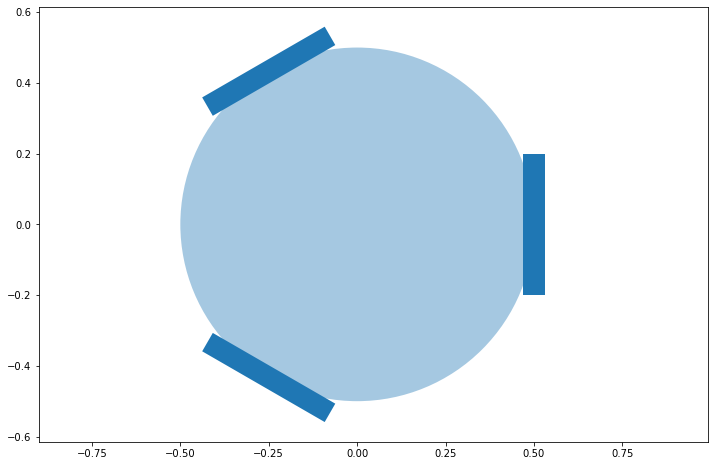

In [5]:
fig, ax = plt.subplots(figsize=(12,8))

circle = Circle((0, 0), R, alpha=0.4)
ax.add_artist(circle)

wheels = []
for i in range(3):
    px, py, theta = wheel_pose(i)
    wheel = Rectangle((-w/2, -r), w, 2*r)
    wheel.set_transform(Affine2D().rotate(theta).translate(px, py))
    wheels.append(wheel)

ax.add_collection(PatchCollection(wheels))
ax.axis('equal'); plt.show()

## Kinematics of Omni Wheels

> From robot velocity to wheel velocity.

Kinematics is the study of moving things. In particular, for our omni-directional robot we will ask "What should the individual wheel velocities be given that we want the robot to move with a certain velocity?"

We will only be concerned with the **translational velocity** $v=(v_x, v_y)$ for now. For a *single* wheel, if the robot moves with velocity $v$, then this induces a velocity at the wheel's location *parallel* and *perpendicular* to the wheel. In particular, for wheel $i$ we have

$$
\begin{align*}
v^i_{\parallel} &= - v_x \sin \theta^i + v_y \cos \theta^i \\
v^i_{\perp} &= v_x \cos \theta^i + v_y \sin \theta^i
\end{align*}
$$

In code:

In [6]:
def wheel_velocity(vx:float, vy:float, i:int):
    """Calulate parallel and perpendicular velocities at wheel i"""
    _, _, theta = wheel_pose(i)
    para = - vx * np.sin(theta) + vy * np.cos(theta)
    perp =   vx * np.cos(theta) + vy * np.sin(theta)
    return para, perp

Below we use this to show how the desired velocity (in blue) translates graphically to parallel (green) and perpendicular (red) velocity components at the wheel sites:

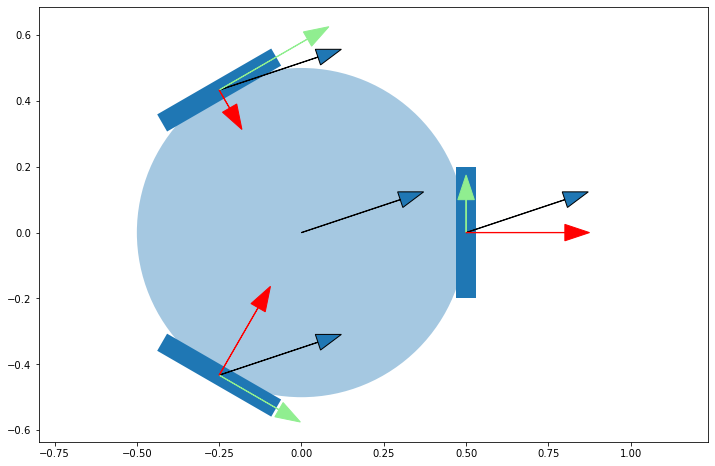

In [7]:
vx, vy = 0.3, 0.1 # change these !

fig, ax = plt.subplots(figsize=(12,8))

circle = Circle((0, 0), R, alpha=0.4)
ax.add_artist(circle)

wheels = []
for i in range(3):
    px, py, theta = wheel_pose(i)
    wheel = Rectangle((-w/2, -r), w, 2*r)
    wheel.set_transform(Affine2D().rotate(theta).translate(px, py))
    wheels.append(wheel)
ax.add_collection(PatchCollection(wheels))


plt.arrow(0, 0, vx, vy, head_width=0.05)
for i in range(3):
    px, py, theta = wheel_pose(i)
    para, perp = wheel_velocity(vx, vy, i)
    plt.arrow(px, py, vx, vy, head_width=0.05)
    plt.arrow(px, py, -np.sin(theta)*para, np.cos(theta)*para, head_width=0.05, color="lightgreen")
    plt.arrow(px, py, np.cos(theta)*perp, np.sin(theta)*perp, head_width=0.05, color="red")

ax.axis('equal'); plt.show()

## The Jacobian Matrix

The motion *perpendicular* to the wheel is not resisted by the rollers: they will just roll at exactly the right speed to accommodate any movement in this direction. Because this allows the wheel to "slide", we also call this the **sliding direction**.

On the other hand, the contact of each wheel has to move exactly opposite to the parallel or **driving direction** of the velocity, because it cannot slide in that direction. As a consequence, if the radius of each wheel is $r$, the angular velocity $\omega^i$ of the wheel has to be

$$\omega^i = \frac{v^i_\parallel}{r}$$

Because we have three wheels, we can combine all of the above in $3\times2$ **Jacobian matrix** that translates a desired robot velocity $v=(v_x,v_y)$ to the appropriate commanded wheel velocities:

$$
\begin{pmatrix}\omega^1 \\ \omega^2 \\ \omega^3 \end{pmatrix} 
= \frac{1}{r}
\begin{pmatrix}- \sin\theta^1 & \cos\theta^1 \\ - \sin\theta^2 & \cos\theta^2 \\ - \sin\theta^3 & \cos\theta^3 
\end{pmatrix}
\begin{pmatrix}v_x \\ v_y \end{pmatrix}
$$

For the three regularly arranged omni wheels with $\theta^1=0$, $\theta^2=2\pi/3$, and $\theta^3=4\pi/3$ this becomes


$$
\begin{pmatrix}\omega^1 \\ \omega^2 \\ \omega^3 \end{pmatrix} 
= \frac{1}{r}
\begin{pmatrix}0 & 1 \\ -0.866 & -0.5 \\ 0.866 & -0.5 
\end{pmatrix}
\begin{pmatrix}v_x \\ v_y \end{pmatrix}
$$

In [8]:
def jacobian_matrix():
    """Compute matrix converting from velocity to wheel velocities."""
    rows = []
    for i in range(num_wheels):
        _, _, theta = wheel_pose(i)
        rows.append([-np.sin(theta), np.cos(theta)])
    return np.array(rows)/r

We can verify that doing the matrix-velocity multiplication yields the same result as using the `wheel_velocity` function:

In [9]:
for i in range(3):
    para, perp = wheel_velocity(vx, vy, i)
    print(f"wheel {i}: {para/r}")

print("\nUsing matrix method:")
print(jacobian_matrix() @ gtsam.Point2(vx, vy))

wheel 0: 0.5
wheel 1: -1.549038105676658
wheel 2: 1.0490381056766573

Using matrix method:
[ 0.5        -1.54903811  1.04903811]


## Omni-directional Movement in Practice

> Additional transforms might be required.

To summarize, given a velocity in the robot's body coordinates, we can multiply it with the Jacobian matrix $J$ to obtain the angular wheel velocities that can be commanded. The above exposition can be directly generalized to an arbitrary number of wheels, mounted in arbitrary locations. Some care needs to be taken that the chosen configuration is not singular, which would result in being only to move in one particular direction (or not at all!).

In general we want a robot to move in a particular direction in the warehouse, or, in general in *world coordinates*. In this chapter we have assumed that the robot orientation is aligned with the warehouse orientation, so conveniently we have to do nothing.However, if one were to model the robot's orientation, we would simply have to rotate the desired world velocity into the body coordinate frame. We will see how to do this later in this book.

If we *do* care about orientation, omni wheels can actually be used to *rotate* the robot, as well. Think about applying the same constant angular velocity to all three wheels: the robot will now simply rotate in place. In other words, we could add a *third* column to the Jacobian matrix that translates a desired angular velocity into wheel velocities. That will allow us to command any combination of linear and angular velocity.

Finally, there is a second type of wheel, the "mecanum wheel", where the rollers are *not* aligned with the wheel rim, but are rotated by some (constant) amount. That complicates the math a little bit, but in the end we will again obtain a Jacobian matrix. We will not discuss this further.

## A Gaussian Dynamic Bayes Net

> Modeling stochastic action in continuous spaces can again be done using DBS.

Modeling with continuous densities is done with *continuous* dynamic bayes nets (DBNs). 
Omni wheels are notoriously flaky in the execution, especially on uneven ground or carpet. Hence, we need to model the uncertainty associated with commanded movements, which are now continuous displacements $u_k\in\mathbb{R}^2$.
Recall that we created a DBN with discrete actions, states, and measurements in the previous chapter. Here we do the same, except with *continuous* densities, specifying a DBN that encodes the joint density $p(X|U)$ on the continuous states $X\doteq\{x_k\}_{k=1}^N$,

$$
p(X|U) = p(x_1) \prod_{k=2}^N p(x_k|x_{k-1}, u_k)
$$

where we assumed the **control variables** $U\doteq\{u_k\}_{k=1}^{N-1}$ as *given* to us.

Let us assume we *know* that the robot starts out in the warehouse at coordinates $\mu_1 =(20,10)$, plus or minus half a meter. We can encode this knowledge into a continuous Gaussian prior as

$$p(x_1) = \mathcal{N}(x_1;\mu=\mu_1,\Sigma=P) \propto \exp\{ - \frac{1}{2} (x_1-\mu_1)^TP^{-1}(x_1-\mu_1) \}$$

with the covariance matrix $P=\text{diag}(0.5^2,0.5^2)$. In code:

A Gaussian *motion model* is a bit trickier. We need to create a **conditional Gaussian density**, where the mean is a linear function of another variable:

$$
p(x_k|x_{k-1}, u_k) = \mathcal{N}(x_k;\mu=A_k x_{k-1} + B u_k, \Sigma=Q)
$$

where $Q$ is the traditional symbol used for motion model covariance. If we assume the robot executes actions $u_k$ with a standard deviation of 20cm, then we will have $Q=\text{diag}(0.2^2,0.2^2)$. As an aside, if you have ever taken a linear controls class, you might recognize the matrices $A$ and $B$ can be recognized as the linear system matrices associated with the motion model.

## Gaussian DBNs in Code


In GTSAM, a Gaussian density is specified using the class `GaussianDensity`, which correspond to a negative log-probability given by 

$$\frac{1}{2 \sigma^2} \|x - \mu\|^2.$$

with a named constructor `FromMeanAndStddev` that takes $\mu$ and $\sigma$. For their part, Gaussian *conditional* densities are specified using the class `GaussianConditional`, which correspond to a negative log-probability given by 

$$\frac{1}{2 \sigma^2} \|x - (A_1 p_1 + A_2 p_2 + b))\|^2.$$

i.e., the mean on $x$ is a linear function of the conditioning variables $p_1$ and $p_2$. Again, a named constructor `FromMeanAndStddev` is there to assist us. Details in the GTSAM 101 section at the end, as always.

All of the above is used in the following piece of code, which builds the dynamic Bayes net:

In [10]:
gaussianBayesNet = gtsam.GaussianBayesNet()
A, B = np.eye(2), np.eye(2)
motion_model_sigma = 0.2
for k in reversed(indices[:-1]):
    gaussianBayesNet.push_back(gtsam.GaussianConditional.FromMeanAndStddev(
        x[k+1], A, x[k], B, u[k], [0, 0], motion_model_sigma))
p_x1 = gtsam.GaussianDensity.FromMeanAndStddev(x[1], [20,10], 0.5)
gaussianBayesNet.push_back(p_x1)

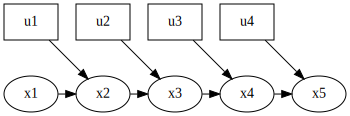

In [11]:
position_hints = {'u': 2, 'x': 1}
show(gaussianBayesNet, hints=position_hints, boxes=set(list(u.values())))

### Exercise

Note that we used a constant motion model noise here, which is perhaps unrealistic: if a robot is commanded to go further, it could be expected to do a worse job at going exactly the distance it was supposed to go. How could you modify the above code to account for that?

## Simulating a Continuous Trajectory

> Bayes nets are great for simulation.

Let us now create a simulated trajectory in our example warehouse, by specifying a "control tape" and using the dynamic Bayes net created above to do the heavy lifting for us:

In [12]:
control_tape = gtsam.VectorValues()
for k, (ux,uy) in zip(indices[:-1], [(2,0), (2,0), (0,2), (0,2)]):
    control_tape.insert(u[k], gtsam.Point2(ux,uy))
control_tape


Variable,value
u1,2 0
u2,2 0
u3,0 2
u4,0 2


In [13]:
gaussianBayesNet.sample(control_tape)

Variable,value
u1,2 0
u2,2 0
u3,0 2
u4,0 2
x1,20.6469 10.199
x2,22.8706 9.90054
x3,24.8089 10.1832
x4,25.1275 12.2733
x5,25.0941 14.5563


## GTSAM 101

> The GTSAM concepts used in this section, explained.

A `gtsam.GaussianDensity` class can be constructed via the following named constructor:

```python
FromMeanAndStddev(key: gtsam.Key, mean: np.array, sigma: float) -> gtsam.GaussianDensity
```

and a two similar named constructors exists for `gtsam.GaussianConditional`:

```python
- FromMeanAndStddev(key: gtsam.Key, A: np.array, parent: gtsam.Key, b: numpy.ndarray[numpy.float64[m, 1]], sigma: float) -> gtsam.GaussianConditional
      
- FromMeanAndStddev(key: gtsam.Key, A1: np.array, parent1: gtsam.Key, A2: np.array, parent2: gtsam.Key, b: np.array, sigma: float) -> gtsam.GaussianConditional
```

Both classes support some other methods that can come in handy, as demonstrated here on the prior created above:

In [14]:
print(p_x1) # printing

values = gtsam.VectorValues()
values.insert(x[1], [19,12])

e = p_x1.unweighted_error(values)
print(f"unweighted error vector = {e}")

w = p_x1.error_vector(values)
print(f"weighted error vector = {w}")

E  = p_x1.error(values)
print(f"error 0.5 w'*w = {E}")
assert E == 0.5 * w.dot(w) # check 10 == (4+16)/2

GaussianDensity: density on [x1] 
mean: [20; 10];
covariance: [
	0.25, 0;
	0, 0.25
]
isotropic dim=2 sigma=0.5

unweighted error vector = [-1.  2.]
weighted error vector = [-2.  4.]
error 0.5 w'*w = 10.0


In the above, all error functions take an instance of `gtsam.VectorValues`, which is simply a map from GTSAM keys to values as vectors. This is the equivalent of `gtsam.DiscreteValues` from the previous sections.